# **Análise Exploratória**

- Inspecionar o dataset
- Estatísticas descritivas
- Distribuição de dados (esp. target)
- Pré-tratamento de dados p/efetuar análises, extrair insights (correlações, etc)

## Configuração de exibição do Pandas

In [74]:
# Configurar pandas para não exibir números em notação científica
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Configurar pandas para exibir todas as colunas
pd.options.display.max_columns=4000
pd.options.display.max_rows = 999

## Bibliotecas

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

## Funções

In [80]:
# Função para ler ou gravar dados no banco SQL
def manage_db(operation, table_name, db_path, df=None):
    """
    Função para ler ou gravar dados no banco de dados SQLite 'house_prices.db'.

    Parâmetros:
    operation (str): 'r' para ler ou 'w' para gravar.
    table_name (str): Nome da tabela para ler ou gravar.
    df (pd.DataFrame, opcional): DataFrame para gravar na tabela (necessário se operação for 'w').

    Retorna:
    pd.DataFrame se operação for 'r'. None se operação for 'w'.
    """
   
    # conecta ao banco de dados
    conn = sqlite3.connect(db_path)

    # Se for operação de leitura
    if operation == 'r':
        query = f"SELECT * FROM {table_name}"
        df = pd.read_sql(query, conn)
        conn.close()
        return df
    
    # Se for operação de escrita (salvar df)
    elif operation == 'w' and df is not None:
        df.to_sql(table_name, conn, if_exists='replace', index=False)
        conn.close()
        return None
    
    else:
        conn.close()
        raise ValueError("Operação inválida ou DataFrame não fornecido para escrita.")
# ---------------------------------------------------------------------------------------

# Função para converter os tipos das colunas do dataset
def convert_column_types(dataframe, column_types:dict):

    df = dataframe.copy()
    
    for column, dtype in column_types.items():
        df[column] = pd.to_numeric(df[column], errors='coerce') if dtype in [int, float] else df[column].astype(dtype)
    return df
# ---------------------------------------------------------------------------------------

# Função para converter as colunas especificadas para o tipo 'category'
def convert_columns_to_category(df, columns):
    for column in columns:
        if column in df.columns:
            df[column] = df[column].astype('category')
    return df
# ---------------------------------------------------------------------------------------

# Função para plotar gráficos de barras horizontais da % de valores nulos por coluna
def plot_null_percentage(df, output_file=None, min_null_percentage=1):
    """
    Plota o gráfico da porcentagem de valores nulos por coluna para um DataFrame.
    
    Parâmetros:
    df (pd.DataFrame): DataFrame para análise.
    output_file (str): Caminho do arquivo para salvar o gráfico.
    min_null_percentage (float): Porcentagem mínima de valores nulos para incluir no gráfico.
    """
    # Calcular a porcentagem de valores nulos por coluna
    null_percentage = df.isnull().mean() * 100

    # Ordenar em ordem decrescente
    null_percentage_sorted = null_percentage.sort_values(ascending=False)

    # Filtrar colunas com pelo menos min_null_percentage de valores nulos
    null_percentage_sorted = null_percentage_sorted[null_percentage_sorted >= min_null_percentage]

    # Criar DataFrame para o gráfico
    plot_data = pd.DataFrame({
        'Column': null_percentage_sorted.index,
        'Null Percentage': null_percentage_sorted.values,
        'Hue': null_percentage_sorted.index  # Adicionar coluna para hue
    })

    # Criar o gráfico de barras horizontais
    plt.figure(figsize=(9, 4))
    ax = sns.barplot(x='Null Percentage', y='Column', data=plot_data, hue='Hue', palette="viridis", legend=False)

    # Configurar o gráfico
    ax.set_title("Porcentagem de Valores Nulos por Coluna (>= {:.1f}%)".format(min_null_percentage))
    ax.set_xlabel("Porcentagem de Valores Nulos (%)")
    ax.set_ylabel("Coluna")

    # Ajustar o layout e salvar o gráfico
    plt.tight_layout()

    if output_file is not None:
        plt.savefig(output_file)
    plt.show()
    plt.close()
# ---------------------------------------------------------------------------------------

# Função para imputar valores faltantes usando o MICE
def impute_mice_and_mode(df):
    # Separar colunas numéricas e categóricas
    numeric_cols = df.select_dtypes(include=['number']).columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    
    # Criar o imputador MICE (IterativeImputer)
    imputer_mice = IterativeImputer(estimator=LinearRegression(), max_iter=10, random_state=0)
    
    # Imputar valores faltantes nas colunas numéricas
    df_numeric_imputed = pd.DataFrame(imputer_mice.fit_transform(df[numeric_cols]), columns=numeric_cols, index=df.index)
    
    # Imputar valores faltantes nas colunas categóricas com moda
    df_categorical_imputed = df[categorical_cols].copy()  # Faz uma cópia do DataFrame
    for col in categorical_cols:
        mode_value = df[col].mode()[0]
        df_categorical_imputed[col] = df_categorical_imputed[col].fillna(mode_value)  # Imputa a moda
    
    # Concatenar os DataFrames imputados
    df_imputed = pd.concat([df_numeric_imputed, df_categorical_imputed], axis=1)
    
    return df_imputed
# ---------------------------------------------------------------------------------------

# Função para plotar os boxplots das cols numéricas numa grid
def plot_boxplots(df, filename):
    # Selecionar colunas numéricas
    numeric_cols = df.select_dtypes(include=['number']).columns
    
    # Número de colunas para a grid
    n_cols = 5
    n_rows = len(numeric_cols) // n_cols + (len(numeric_cols) % n_cols > 0)
    
    # Criar a figura
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
    
    # Iterar sobre cada coluna e criar o boxplot
    for i, col in enumerate(numeric_cols):
        row = i // n_cols
        col_idx = i % n_cols
        sns.boxplot(data=df, x=col, ax=axes[row, col_idx])
        axes[row, col_idx].set_title(col)
    
    # Remover subplots vazios
    for j in range(i + 1, n_rows * n_cols):
        row = j // n_cols
        col_idx = j % n_cols
        fig.delaxes(axes[row, col_idx])
    
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()
    plt.close()

## Carregando dados

In [5]:
df_train = manage_db(operation='r', table_name='df_train', db_path='data/house_prices.db')
df_train.head()

,Type,Region,MunicipalityCode,Prefecture,Municipality,DistrictName,NearestStation,TimeToNearestStation,MinTimeToNearestStation,MaxTimeToNearestStation,...,Breadth,CityPlanning,CoverageRatio,FloorAreaRatio,Period,Year,Quarter,Renovation,Remarks,TradePrice
0,Pre-owned Condominiums etc.,,13103,Tokyo,Minato Ward,Kaigan,Takeshiba,1,1.0,1.0,...,,Quasi-industrial Zone,60.0,400.0,1st quarter 2011,2011,1,Done,,24000000
1,Residential Land(Land and Building),Residential Area,13120,Tokyo,Nerima Ward,Nishiki,Kamiitabashi,15,15.0,15.0,...,4.0,Category I Exclusively Low-story Residential Zone,60.0,200.0,3rd quarter 2013,2013,3,,Dealings including private road,51000000
2,Residential Land(Land Only),Residential Area,13201,Tokyo,Hachioji City,Shimoongatamachi,Takao (Tokyo),1H-1H30,60.0,90.0,...,4.5,Category I Exclusively Low-story Residential Zone,40.0,80.0,4th quarter 2007,2007,4,,,14000000
3,Pre-owned Condominiums etc.,,13208,Tokyo,Chofu City,Kamiishiwara,Nishichofu,16,16.0,16.0,...,,Quasi-industrial Zone,60.0,200.0,2nd quarter 2015,2015,2,Not yet,,23000000
4,Residential Land(Land Only),Residential Area,13117,Tokyo,Kita Ward,Shimo,Shimo,6,6.0,6.0,...,4.5,Category I Exclusively Medium-high Residential...,60.0,200.0,4th quarter 2015,2015,4,,,33000000


## Informações Gerais do Dataset

- Dimensões
- Nomenclatura de colunas
- Estatísticas Descritivas
- Presença de nulos, duplicados
- Checagem de tipos
- Outliers
- Avaliação de Colunas

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325260 entries, 0 to 325259
Data columns (total 37 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   Type                         325260 non-null  object
 1   Region                       325260 non-null  object
 2   MunicipalityCode             325260 non-null  object
 3   Prefecture                   325260 non-null  object
 4   Municipality                 325260 non-null  object
 5   DistrictName                 325260 non-null  object
 6   NearestStation               325260 non-null  object
 7   TimeToNearestStation         325260 non-null  object
 8   MinTimeToNearestStation      325260 non-null  object
 9   MaxTimeToNearestStation      325260 non-null  object
 10  FloorPlan                    325260 non-null  object
 11  Area                         325260 non-null  object
 12  AreaIsGreaterFlag            325260 non-null  object
 13  UnitPrice     

### Checagem de tipos

Todas as colunas estão no formato 'string'. Vamos convertê-las aos tipos corretos.

In [19]:
# Mapeando os tipos corretos das colunas
column_types = {
    'Type': str,
    'Region': str,
    'MunicipalityCode': int,
    'Prefecture': str,
    'Municipality': str,
    'DistrictName': str,
    'NearestStation': str,
    'TimeToNearestStation': str,
    'MinTimeToNearestStation': int,
    'MaxTimeToNearestStation': int,
    'FloorPlan': str,
    'Area': int,
    'AreaIsGreaterFlag': int,
    'UnitPrice': float,
    'PricePerTsubo': float,
    'LandShape': str,
    'Frontage': float,
    'FrontageIsGreaterFlag': int,
    'TotalFloorArea': int,
    'TotalFloorAreaIsGreaterFlag': int,
    'BuildingYear': int,
    'PrewarBuilding': int,
    'Structure': str,
    'Use': str,
    'Purpose': str,
    'Direction': str,
    'Classification': str,
    'Breadth': float,
    'CityPlanning': str,
    'CoverageRatio': int,
    'FloorAreaRatio': int,
    'Period': str,
    'Year': int,
    'Quarter': int,
    'Renovation': str,
    'Remarks': str,
    'TradePrice': int
}

df_train = convert_column_types(df_train, column_types)
df_train.dtypes

Type                            object
Region                          object
MunicipalityCode                 int64
Prefecture                      object
Municipality                    object
DistrictName                    object
NearestStation                  object
TimeToNearestStation            object
MinTimeToNearestStation        float64
MaxTimeToNearestStation        float64
FloorPlan                       object
Area                             int64
AreaIsGreaterFlag                int64
UnitPrice                      float64
PricePerTsubo                  float64
LandShape                       object
Frontage                       float64
FrontageIsGreaterFlag          float64
TotalFloorArea                 float64
TotalFloorAreaIsGreaterFlag      int64
BuildingYear                   float64
PrewarBuilding                   int64
Structure                       object
Use                             object
Purpose                         object
Direction                

### Estatística Descritiva

In [23]:
# estatísticas descritivas das colunas numéricas
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
MunicipalityCode,325260.0000,13139.8000,46.1000,13101.0000,13110.0000,13117.0000,13201.0000,13421.0000
MinTimeToNearestStation,317002.0000,10.1900,7.9900,0.0000,5.0000,8.0000,13.0000,120.0000
MaxTimeToNearestStation,316879.0000,11.1200,11.6200,0.0000,5.0000,8.0000,13.0000,120.0000
Area,325260.0000,117.1700,204.3000,10.0000,50.0000,70.0000,115.0000,5000.0000
AreaIsGreaterFlag,325260.0000,0.0000,0.0600,0.0000,0.0000,0.0000,0.0000,1.0000
UnitPrice,63585.0000,425872.3400,476035.1500,4.0000,200000.0000,340000.0000,540000.0000,20000000.0000
PricePerTsubo,63585.0000,1407507.5900,1571121.5200,13.0000,680000.0000,1100000.0000,1800000.0000,66000000.0000
Frontage,162145.0000,9.6300,6.6100,0.5000,5.9000,8.0000,11.4000,50.0000
FrontageIsGreaterFlag,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TotalFloorArea,109005.0000,172.8300,268.1900,10.0000,85.0000,95.0000,120.0000,2000.0000


Algumas colunas, apesar de numéricas, na verdade representam categorias. Vamos exibir as estatísticas apenas das colunas realmente numéricas:

In [ ]:
"""Convertendo colunas de categorias para o tipo CATEGORY
- ATENÇÃO: o Pandas não preserva o tipo category ao salvar em CSV.
- Ou seja, se você salvar em csv, depois de ler esse arquivo vai precisar fazer essa conversão para category novamente.
"""

# Lista de todas as colunas a serem convertidas para 'category'
columns_to_category = [
    'Type', 'Region', 'MunicipalityCode', 'Prefecture', 'Municipality',
    'DistrictName', 'NearestStation', 'FloorPlan', 'AreaIsGreaterFlag',
    'LandShape', 'FrontageIsGreaterFlag', 'TotalFloorAreaIsGreaterFlag',
    'BuildingYear','PrewarBuilding', 'Structure', 'Use', 'Purpose', 'Direction',
    'Classification', 'CityPlanning', 'Period', 'Year', 'Quarter', 'Renovation'
]

# Aplicar a função ao DataFrame df_train
df_train = convert_columns_to_category(df_train, columns_to_category)

# Exibir os tipos das colunas para verificar
# print(df_train.dtypes)

In [6]:
# estatísticas descritivas das colunas REALMENTE numéricas
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
MinTimeToNearestStation,317002.0000,10.1921,7.9879,0.0000,5.0000,8.0000,13.0000,120.0000
MaxTimeToNearestStation,316879.0000,11.1168,11.6177,0.0000,5.0000,8.0000,13.0000,120.0000
Area,325260.0000,117.1717,204.3001,10.0000,50.0000,70.0000,115.0000,5000.0000
UnitPrice,63585.0000,425872.3408,476035.1482,4.0000,200000.0000,340000.0000,540000.0000,20000000.0000
PricePerTsubo,63585.0000,1407507.5921,1571121.5177,13.0000,680000.0000,1100000.0000,1800000.0000,66000000.0000
Frontage,162145.0000,9.6299,6.6108,0.5000,5.9000,8.0000,11.4000,50.0000
TotalFloorArea,109005.0000,172.8341,268.1946,10.0000,85.0000,95.0000,120.0000,2000.0000
Breadth,173966.0000,6.2479,4.8746,1.0000,4.0000,5.0000,6.0000,85.0000
CoverageRatio,320607.0000,62.1485,13.1330,30.0000,60.0000,60.0000,80.0000,80.0000
FloorAreaRatio,320607.0000,265.5521,159.6709,50.0000,150.0000,200.0000,300.0000,1200.0000


Salvando dataset com tipos corrigidos:

In [36]:
df_train.to_csv('data/train_corrected.csv', index=None)

### Tratamento de Nulos e Duplicados

In [24]:
df_train = pd.read_csv('data/train_corrected.csv')

In [25]:
"""Convertendo colunas de categorias para o tipo CATEGORY
- ATENÇÃO: o Pandas não preserva o tipo category ao salvar em CSV.
- Ou seja, se você salvar em csv, depois de ler esse arquivo vai precisar fazer essa conversão para category novamente.
"""

# Lista de todas as colunas a serem convertidas para 'category'
columns_to_category = [
    'Type', 'Region', 'MunicipalityCode', 'Prefecture', 'Municipality',
    'DistrictName', 'NearestStation', 'FloorPlan', 'AreaIsGreaterFlag',
    'LandShape', 'FrontageIsGreaterFlag', 'TotalFloorAreaIsGreaterFlag',
    'BuildingYear','PrewarBuilding', 'Structure', 'Use', 'Purpose', 'Direction',
    'Classification', 'CityPlanning', 'Period', 'Year', 'Quarter', 'Renovation'
]

# Aplicar a função ao DataFrame df_train
df_train = convert_columns_to_category(df_train, columns_to_category)

# Exibir os tipos das colunas para verificar
print(df_train.dtypes)

Type                           category
Region                         category
MunicipalityCode               category
Prefecture                     category
Municipality                   category
DistrictName                   category
NearestStation                 category
TimeToNearestStation             object
MinTimeToNearestStation         float64
MaxTimeToNearestStation         float64
FloorPlan                      category
Area                              int64
AreaIsGreaterFlag              category
UnitPrice                       float64
PricePerTsubo                   float64
LandShape                      category
Frontage                        float64
FrontageIsGreaterFlag          category
TotalFloorArea                  float64
TotalFloorAreaIsGreaterFlag    category
BuildingYear                   category
PrewarBuilding                 category
Structure                      category
Use                            category
Purpose                        category


#### Duplicados

In [26]:
# Duplicados
percentage_duplicates = df_train.duplicated().sum()/len(df_train)*100
print(f"Percentual de linhas duplicadas: {percentage_duplicates:.2f}%")

Percentual de linhas duplicadas: 0.76%


Como a quantidade de linhas duplicadas é pequena, vou remover essas linhas do dataset de Treino.

In [27]:
# Exibir o número de linhas ANTES da remoção
print(f"Número de linhas antes da remoção de duplicadas: {len(df_train)}")

# Remover linhas duplicadas
df_train.drop_duplicates(inplace=True)

# Exibir o número de linhas restantes após a remoção
print(f"Número de linhas após remoção de duplicadas: {len(df_train)}")

Número de linhas antes da remoção de duplicadas: 325260
Número de linhas após remoção de duplicadas: 322796


#### Valores Nulos

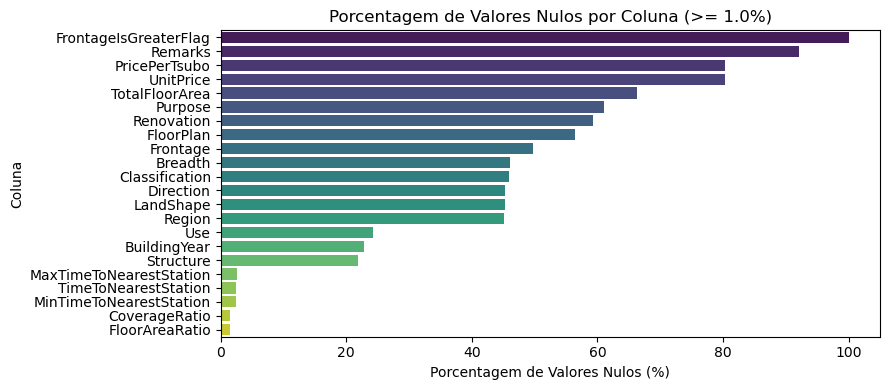

In [28]:
# Plotando % de valores nulos por coluna
plot_null_percentage(df_train,'img/train_nulos.png')

**Política de tratamento de valores nulos:**
- **Colunas com mais de 50% nulos:** remover do dataset.
- **Colunas com até 50% nulos:** imputar valores usando o MICE.

**Por quê escolhi o MICE?**
- Minha primeira escolha foi o KNN.
- Ele considera todas as colunas para estimar o valor faltante.
- Mas a execução dele ultrapassou 13 minutos e não terminou. Resolvi stopar.
- O MICE utiliza regressão (um algo mais simples) entre cada coluna e a coluna em tratamento. Ele 'quebra' o problema em partes menores.
- Isso torna ele muito escalável para datasets grandes como este.

In [35]:
# Removendo colunas com mais de 50% nulos

# Calcular a porcentagem de valores nulos por coluna
null_percentage = df_train.isnull().mean() * 100

# Identificando colunas com mais de 70% de valores nulos
cols_to_drop = null_percentage[null_percentage > 50].index

# Removendo essas colunas do DataFrame
df_train_cleaned = df_train.drop(columns=cols_to_drop)

In [ ]:
# Aplicar a função ao DataFrame df_train_cleaned
df_train_cleaned_mice = impute_mice_and_mode(df_train_cleaned)

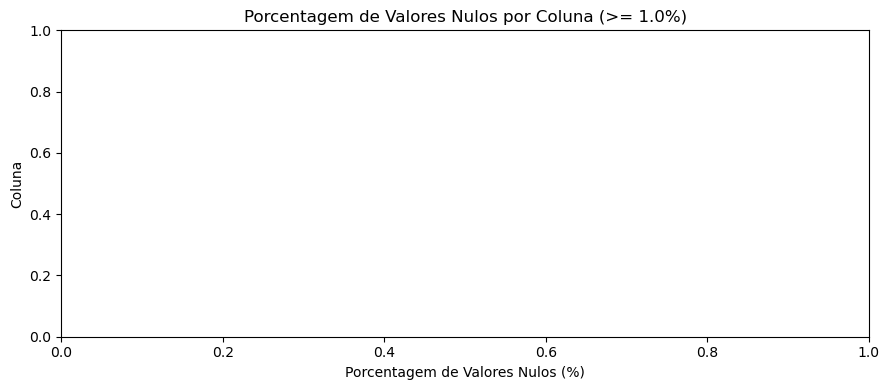

In [69]:
# Plotando % de valores nulos após o tratamento
plot_null_percentage(df_train_cleaned_mice)

In [70]:
# Salvando dataset limpo e com nulos tratados:
df_train_cleaned_mice.to_csv('data/train_nulls_imputted.csv', index=False)

### Tratamento de Outliers

In [76]:
df_train = pd.read_csv('data/train_nulls_imputted.csv')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322796 entries, 0 to 322795
Data columns (total 29 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   MunicipalityCode             322796 non-null  float64
 1   MinTimeToNearestStation      322796 non-null  float64
 2   MaxTimeToNearestStation      322796 non-null  float64
 3   Area                         322796 non-null  float64
 4   AreaIsGreaterFlag            322796 non-null  float64
 5   Frontage                     322796 non-null  float64
 6   TotalFloorAreaIsGreaterFlag  322796 non-null  float64
 7   BuildingYear                 322796 non-null  float64
 8   PrewarBuilding               322796 non-null  float64
 9   Breadth                      322796 non-null  float64
 10  CoverageRatio                322796 non-null  float64
 11  FloorAreaRatio               322796 non-null  float64
 12  Year                         322796 non-null  float64
 13 

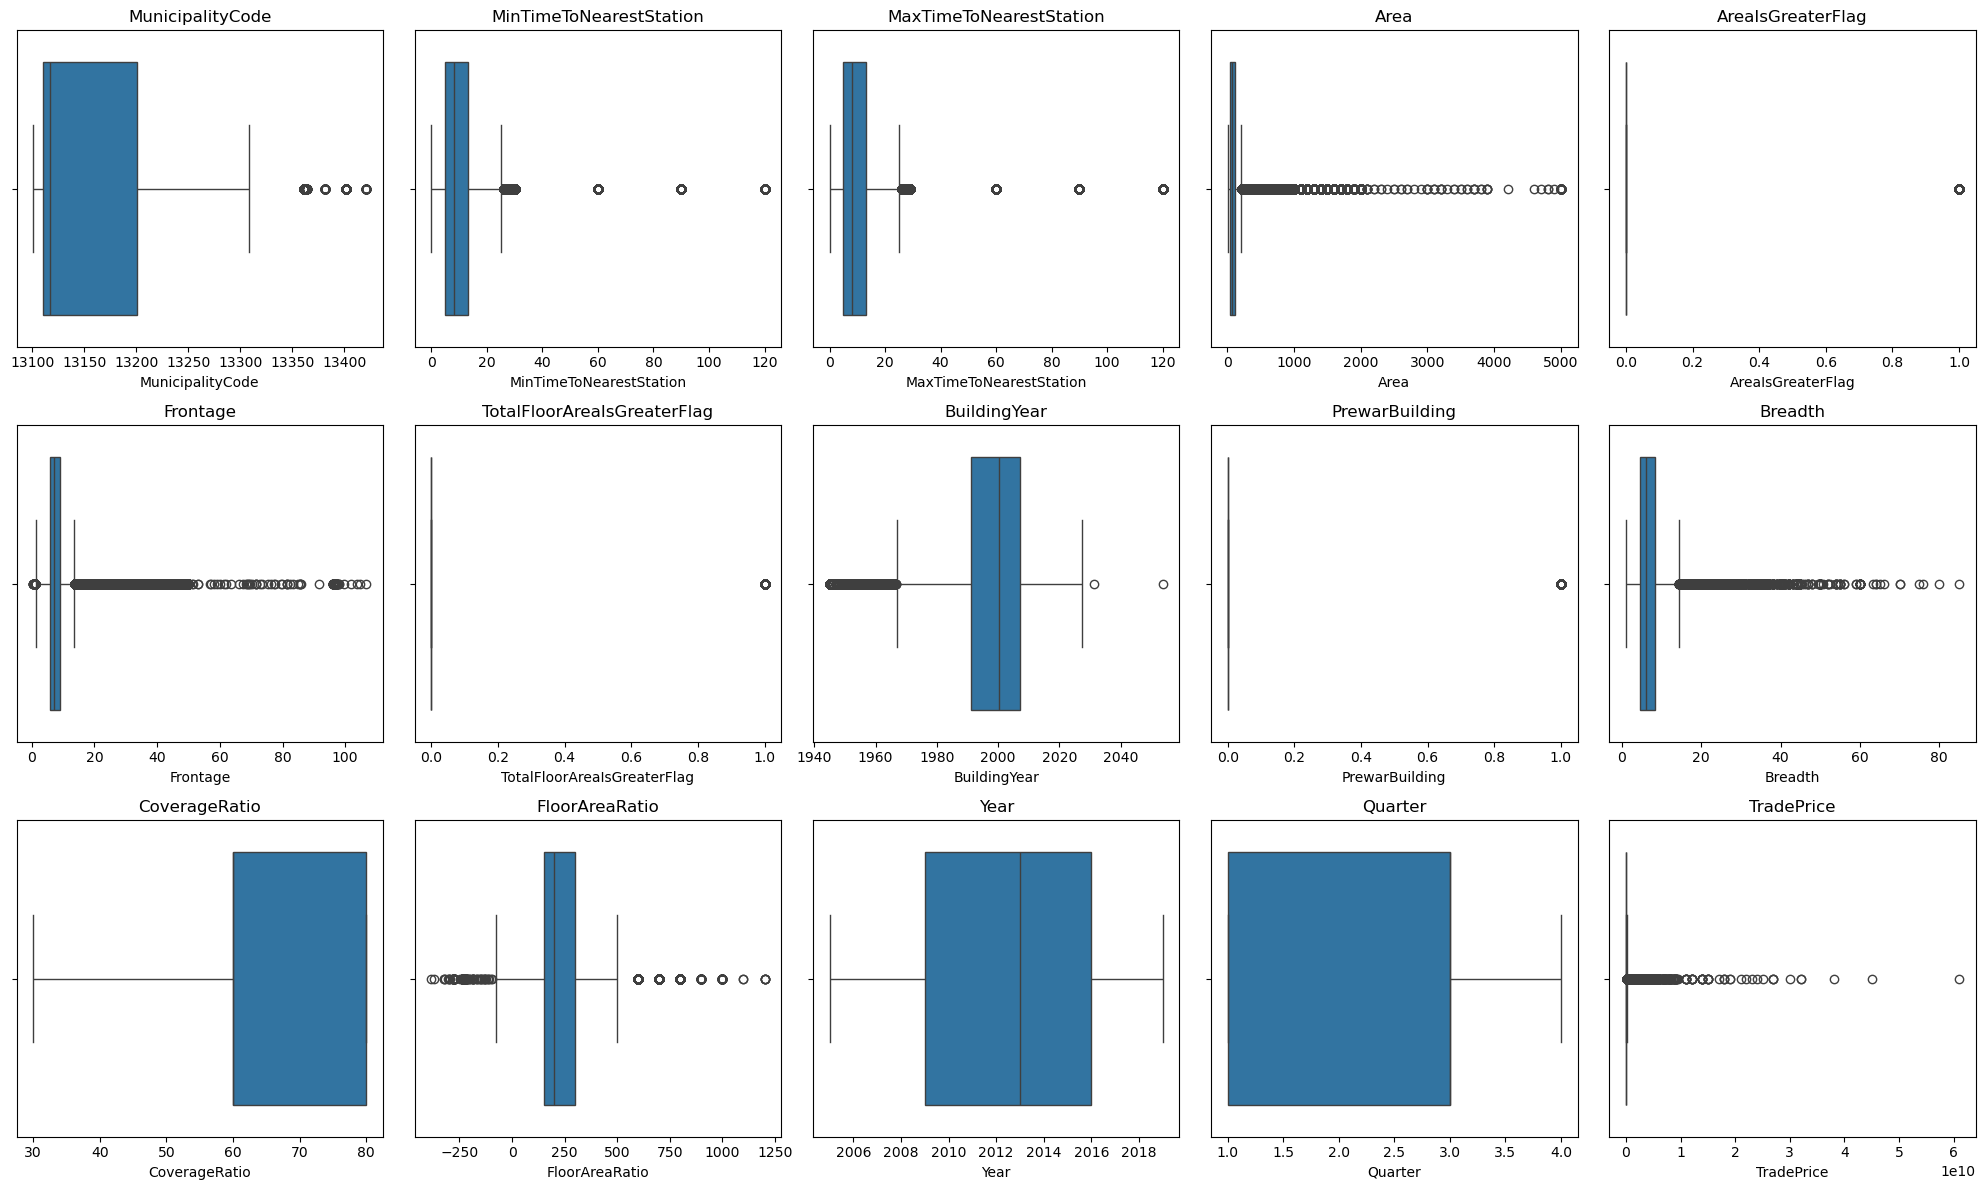

In [79]:
# Plotar os boxplots para o DataFrame df_train para ter uma ideia da distribuição dos dados
plot_boxplots(df_train)

#### Outliers em TradePrice

In [86]:
df_train['TradePrice'].describe()

count        322796.0000
mean       66445058.7836
std       325745082.3655
min            1000.0000
25%        22000000.0000
50%        35000000.0000
75%        54000000.0000
max     61000000000.0000
Name: TradePrice, dtype: float64

O valor máximo de TradePrice é de 61 **bilhões**, muito acima do percentil 75. Isso indica a presença de dados muito extremos.

Vamos tentar encontrar um ponto de corte de outliers.

In [94]:
# Calcular e imprimir os percentis de 'TradePrice'
percentis = df_train['TradePrice'].quantile([0.90, 0.95, 0.99, 0.995])
print("Percentis de TradePrice: (milhões de yen)")
print(percentis/1000000)

Percentis de TradePrice: (milhões de yen)
0.9000     93.0000
0.9500    160.0000
0.9900    600.0000
0.9950   1000.0000
Name: TradePrice, dtype: float64


In [93]:
df_train.shape

(322796, 29)

In [95]:
# Imprimir a quantidade de linhas acima de cada percentil
for perc in percentis.index:
    count = (df_train['TradePrice'] > percentis[perc]).sum()
    print(f"Quantidade de linhas acima do percentil {int(perc * 100)}: {count}")

Quantidade de linhas acima do percentil 90: 32109
Quantidade de linhas acima do percentil 95: 16018
Quantidade de linhas acima do percentil 99: 3218
Quantidade de linhas acima do percentil 99: 1594


Para não prejudicar o modelo e, também, não perder muita informação, vou remover as linhas com preço acima do percentil 95: 16.018 linhas (5% das linhas de df_train).

In [96]:
# Calcular o valor do percentil 95 de 'TradePrice'
percentil_95 = df_train['TradePrice'].quantile(0.95)

# Remover as linhas com 'TradePrice' acima do percentil 95
df_train_filtered = df_train[df_train['TradePrice'] <= percentil_95]

In [97]:
df_train_filtered.shape

(306778, 29)